The previous Notebook in this series used multi-group mode to perform a calculation with previously defined cross sections.  However, in many circumstances the multi-group data is not given and one must instead generate the cross sections for the specific application (or at least verify the use of cross sections from another application).  

This Notebook illustrates the use of the openmc.mgxs.Library class specifically for the calculation of MGXS to be used in OpenMC's multi-group mode. This example notebook is therefore very similar to the MGXS Part III notebook, except OpenMC is used as the multi-group solver instead of OpenMOC.

During this process, this notebook will illustrate the following features:

   - Calculation of multi-group cross sections for a fuel assembly
   - Automated creation and storage of MGXS with openmc.mgxs.Library
   - Steady-state pin-by-pin fission rates comparison between continuous-energy and multi-group OpenMC.
   - Modification of the scattering data in the library to show the flexibility of the multi-group solver


# Generate Input Files

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import openmc

%matplotlib inline

We will begin by creating three materials for the fuel, water, and cladding of the fuel pins.

In [2]:
# 1.6% enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_element('U', 1., enrichment=1.6)
fuel.add_element('O', 2.)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Zr', 1.)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_element('H', 4.9457e-2)
water.add_element('O', 2.4732e-2)
water.add_element('B', 8.0042e-6)


With our three materials, we can now create a Materials object that can be exported to an actual XML file.

In [3]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, zircaloy, water))

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins and control rod guide tubes for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [4]:
# Create cylinders for the fuel and clad
# The x0 and y0 parameters (0. and 0.) are the default values for an
# openmc.ZCylinder object. We could therefore leave them out to no effect
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='reflective')
min_y = openmc.YPlane(y0=-10.71, boundary_type='reflective')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [5]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

Likewise, we can construct a control rod guide tube with the same surfaces.

In [6]:
# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = water
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [7]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

Next, we create a NumPy array of fuel pin and guide tube universes for the lattice.

In [8]:
# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:, :] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [9]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(name='root universe', universe_id=0)
root_universe.add_cell(root_cell)

Before proceeding lets check the geometry.

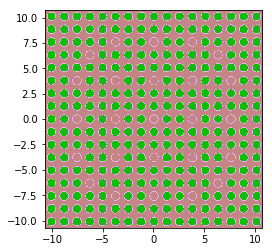

In [10]:
root_universe.plot(origin=(0., 0., 0.), width=(21.42, 21.42), pixels=(500, 500), color_by='material')

Looks good!

We now must create a geometry that is assigned a root universe and export it to XML.

In [11]:
# Create Geometry and set root universe
geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters.

In [12]:
# OpenMC simulation parameters
batches = 600
inactive = 50
particles = 3000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}
settings_file.run_mode = 'eigenvalue'
settings_file.verbosity = 4

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

# Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in EnergyGroups class.

In [13]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups([0., 0.625, 20.0e6])

Next, we will instantiate an openmc.mgxs.Library for the energy groups with our the fuel assembly geometry.

In [14]:
# Initialize a 2-group MGXS Library for OpenMC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

Now, we must specify to the Library which types of cross sections to compute. OpenMC's multi-group mode can accept isotropic flux-weighted cross sections or angle-dependent cross sections, as well as supporting anisotropic scattering represented by either Legendre polynomials, histogram, or tabular angular distributions.  We will create the following multi-group cross sections needed to run an OpenMC simulation to verify the accuracy of our cross sections: "total", "absorption", "nu-fission", '"fission", "nu-scatter matrix", "multiplicity matrix", and "chi".

The "multiplicity matrix" type is a relatively rare cross section type.  This data is needed to provide OpenMC's multi-group mode with additional information needed to accurately treat scattering multiplication (i.e., (n,xn) reactions)), including how this multiplication varies depending on both incoming and outgoing neutron energies.

In [15]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission',
                       'nu-scatter matrix', 'multiplicity matrix', 'chi']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports "material", "cell", "universe", and "mesh" domain types. In this simple example, we wish to compute multi-group cross sections only for each material and therefore will use a "material" domain type.

**NOTE:** By default, the `Library` class will instantiate `MGXS` objects for each and every domain (material, cell, universe, or mesh) in the geometry of interest. However, one may specify a subset of these domains to the `Library.domains` property.

In [16]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = "material"

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = geometry.get_all_materials().values()

We will instruct the library to not compute cross sections on a nuclide-by-nuclide basis, and instead to focus on generating material-specific macroscopic cross sections.

**NOTE:** The default value of the `by_nuclide` parameter is `False`, so the following step is not necessary but is included for illustrative purposes.

In [17]:
# Do not compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = False

Now we will set the scattering order that we wish to use.  For this problem we will use P3 scattering.  A warning is expected telling us that the default behavior (a P0 correction on the scattering data) is over-ridden by our choice of using a Legendre expansion to treat anisotropic scattering.

In [18]:
# Set the Legendre order to 3 for P3 scattering
mgxs_lib.legendre_order = 3

/home/nelsonag/git/openmc/openmc/mgxs/library.py:412: RuntimeWarning: The P0 correction will be ignored since the scattering order 0 is greater than zero
  warn(msg, RuntimeWarning)


Now that the `Library` has been setup let's verify that it contains the types of cross sections which meet the needs of OpenMC's multi-group solver.  Note that this step is done automatically when writing the Multi-Group Library file later in the process (as part of `mgxs_lib.write_mg_library()`), but it is a good practice to also run this before spending all the time running OpenMC to generate the cross sections.

If no error is raised, then we have a good set of data.

In [19]:
# Check the library - if no errors are raised, then the library is satisfactory.
mgxs_lib.check_library_for_openmc_mgxs()

Great, now we can use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each domain.

In [20]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

The tallies can now be exported to a "tallies.xml" input file for OpenMC.

**NOTE:** At this point the `Library` has constructed nearly 100 distinct Tally objects. The overhead to tally in OpenMC scales as O(N) for N tallies, which can become a bottleneck for large tally datasets. To compensate for this, the Python API's `Tally`, `Filter` and `Tallies` classes allow for the smart merging of tallies when possible. The `Library` class supports this runtime optimization with the use of the optional `merge` parameter (`False` by default) for the `Library.add_to_tallies_file(...)` method, as shown below.

In [21]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a fission rate mesh tally that we will eventually use to compare with the corresponding multi-group results.

In [22]:
# Instantiate a tally Mesh
mesh = openmc.RegularMesh()
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally, merge=True)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=66.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Filter instance already exists with id=11.
  warn(msg, IDWarning)


Time to run the calculation and get our results!

In [23]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

To make sure the results we need are available after running the multi-group calculation, we will now rename the statepoint and summary files.

In [24]:
# Move the statepoint File
ce_spfile = './statepoint_ce.h5'
os.rename('statepoint.' + str(batches) + '.h5', ce_spfile)
# Move the Summary file
ce_sumfile = './summary_ce.h5'
os.rename('summary.h5', ce_sumfile)

# Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files.  Let's begin by loading the StatePoint file.

In [25]:
# Load the statepoint file
sp = openmc.StatePoint(ce_spfile, autolink=False)

# Load the summary file in its new location
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [26]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

The next step will be to prepare the input for OpenMC to use our newly created multi-group data.

# Multi-Group OpenMC Calculation

We will now use the `Library` to produce a multi-group cross section data set for use by the OpenMC multi-group solver.  
Note that since this simulation included so few histories, it is reasonable to expect some data has not had any scores, and thus we could see division by zero errors.  This will show up as a runtime warning in the following step. The `Library` class is designed to gracefully handle these scenarios.

In [27]:
# Create a MGXS File which can then be written to disk
mgxs_file = mgxs_lib.create_mg_library(xs_type='macro', xsdata_names=['fuel', 'zircaloy', 'water'])

# Write the file to disk using the default filename of "mgxs.h5"
mgxs_file.export_to_hdf5()

OpenMC's multi-group mode uses the same input files as does the continuous-energy mode (materials, geometry, settings, plots, and tallies file).  Differences would include the use of a flag to tell the code to use multi-group transport, a location of the multi-group library file, and any changes needed in the materials.xml and geometry.xml files to re-define materials as necessary. The materials and geometry file changes could be necessary if materials or their nuclide/element/macroscopic constituents need to be renamed.

In this example we have created macroscopic cross sections (by material), and thus we will need to change the material definitions accordingly.

First we will create the new materials.xml file.

In [28]:
# Re-define our materials to use the multi-group macroscopic data
# instead of the continuous-energy data.

# 1.6% enriched fuel UO2
fuel_mg = openmc.Material(name='UO2', material_id=1)
fuel_mg.add_macroscopic('fuel')

# cladding
zircaloy_mg = openmc.Material(name='Clad', material_id=2)
zircaloy_mg.add_macroscopic('zircaloy')

# moderator
water_mg = openmc.Material(name='Water', material_id=3)
water_mg.add_macroscopic('water')

# Finally, instantiate our Materials object
materials_file = openmc.Materials((fuel_mg, zircaloy_mg, water_mg))

# Set the location of the cross sections file
materials_file.cross_sections = 'mgxs.h5'

# Export to "materials.xml"
materials_file.export_to_xml()

/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/nelsonag/git/openmc/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


No geometry file neeeds to be written as the continuous-energy file is correctly defined for the multi-group case as well.

Next, we can make the changes we need to the simulation parameters.
These changes are limited to telling OpenMC to run a multi-group vice contrinuous-energy calculation.

In [29]:
# Set the energy mode
settings_file.energy_mode = 'multi-group'

# Export to "settings.xml"
settings_file.export_to_xml()

Lets clear the tallies file so it doesn't include tallies for re-generating a multi-group library, but then put back in a tally for the fission mesh.

In [30]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()

# Add fission and flux mesh to tally for plotting using the same mesh we've already defined
mesh_tally = openmc.Tally(name='mesh tally')
mesh_tally.filters = [openmc.MeshFilter(mesh)]
mesh_tally.scores = ['fission']
tallies_file.append(mesh_tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()


Before running the calculation let's visually compare a subset of the newly-generated multi-group cross section data to the continuous-energy data. We will do this using the cross section plotting functionality built-in to the OpenMC Python API.

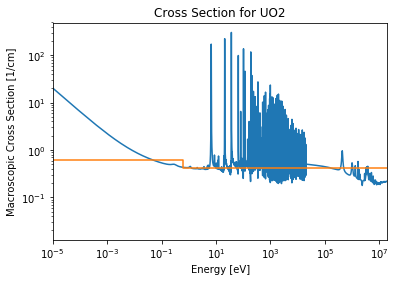

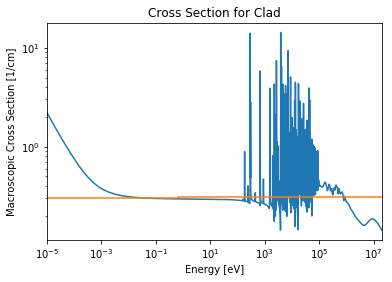

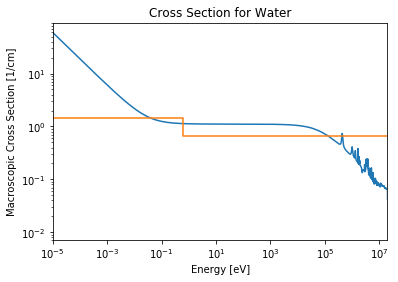

In [31]:
# First lets plot the fuel data
# We will first add the continuous-energy data
fig = openmc.plot_xs(fuel, ['total'])

# We will now add in the corresponding multi-group data and show the result
openmc.plot_xs(fuel_mg, ['total'], plot_CE=False, mg_cross_sections='mgxs.h5', axis=fig.axes[0])
fig.axes[0].legend().set_visible(False)
plt.show()
plt.close()

# Then repeat for the zircaloy data
fig = openmc.plot_xs(zircaloy, ['total'])
openmc.plot_xs(zircaloy_mg, ['total'], plot_CE=False, mg_cross_sections='mgxs.h5', axis=fig.axes[0])
fig.axes[0].legend().set_visible(False)
plt.show()
plt.close()

# And finally repeat for the water data
fig = openmc.plot_xs(water, ['total'])
openmc.plot_xs(water_mg, ['total'], plot_CE=False, mg_cross_sections='mgxs.h5', axis=fig.axes[0])
fig.axes[0].legend().set_visible(False)
plt.show()
plt.close()

At this point, the problem is set up and we can run the multi-group calculation.

In [32]:
# Run the Multi-Group OpenMC Simulation
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

# Results Comparison
Now we can compare the multi-group and continuous-energy results.

We will begin by loading the multi-group statepoint file we just finished writing and extracting the calculated keff.

In [33]:
# Move the StatePoint File
mg_spfile = './statepoint_mg.h5'
os.rename('statepoint.' + str(batches) + '.h5', mg_spfile)
# Move the Summary file
mg_sumfile = './summary_mg.h5'
os.rename('summary.h5', mg_sumfile)

# Rename and then load the last statepoint file and keff value
mgsp = openmc.StatePoint(mg_spfile, autolink=False)

# Load the summary file in its new location
mgsu = openmc.Summary(mg_sumfile)
mgsp.link_with_summary(mgsu)

# Get keff
mg_keff = mgsp.k_combined

Next, we can load the continuous-energy eigenvalue for comparison.

In [34]:
ce_keff = sp.k_combined

Lets compare the two eigenvalues, including their bias

In [35]:
bias = 1.0E5 * (ce_keff - mg_keff)

print('Continuous-Energy keff = {0:1.6f}'.format(ce_keff))
print('Multi-Group keff = {0:1.6f}'.format(mg_keff))
print('bias [pcm]: {0:1.1f}'.format(bias.nominal_value))

Continuous-Energy keff = 1.164600+/-0.000677
Multi-Group keff = 1.164805+/-0.000448
bias [pcm]: -20.4


This shows a small but nontrivial pcm bias between the two methods.  Some degree of mismatch is expected simply to the very few histories being used in these example problems.  An additional mismatch is always inherent in the practical application of multi-group theory due to the high degree of approximations inherent in that method.

# Pin Power Visualizations

Next we will visualize the pin power results obtained from both the Continuous-Energy and Multi-Group OpenMC calculations.

First, we extract volume-integrated fission rates from the Multi-Group calculation's mesh fission rate tally for each pin cell in the fuel assembly.

In [36]:
# Get the OpenMC fission rate mesh tally data
mg_mesh_tally = mgsp.get_tally(name='mesh tally')
mg_fission_rates = mg_mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
mg_fission_rates.shape = (17,17)

# Normalize to the average pin power
mg_fission_rates /= np.mean(mg_fission_rates[mg_fission_rates > 0.])

We can now do the same for the Continuous-Energy results.

In [37]:
# Get the OpenMC fission rate mesh tally data
ce_mesh_tally = sp.get_tally(name='mesh tally')
ce_fission_rates = ce_mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
ce_fission_rates.shape = (17,17)

# Normalize to the average pin power
ce_fission_rates /= np.mean(ce_fission_rates[ce_fission_rates > 0.])

Now we can easily use Matplotlib to visualize the two fission rates side-by-side.

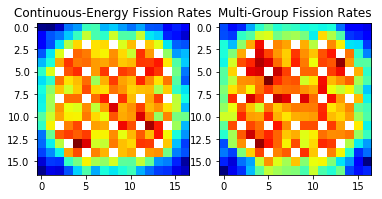

In [38]:
# Force zeros to be NaNs so their values are not included when matplotlib calculates
# the color scale
ce_fission_rates[ce_fission_rates == 0.] = np.nan
mg_fission_rates[mg_fission_rates == 0.] = np.nan

# Plot the CE fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(ce_fission_rates, interpolation='none', cmap='jet')
plt.title('Continuous-Energy Fission Rates')

# Plot the MG fission rates in the right subplot
fig2 = plt.subplot(122)
plt.imshow(mg_fission_rates, interpolation='none', cmap='jet')
plt.title('Multi-Group Fission Rates')


These figures really indicate that more histories are probably necessary when trying to achieve a fully converged solution, but hey, this is good enough for our example!

# Scattering Anisotropy Treatments

We will next show how we can work with the scattering angular distributions. OpenMC's MG solver has the capability to use group-to-group angular distributions which are represented as any of the following: a truncated Legendre series of up to the 10th order, a histogram distribution, and a tabular distribution. Any combination of these representations can be used by OpenMC during the transport process, so long as all constituents of a given material use the same representation. This means it is possible to have water represented by a tabular distribution and fuel represented by a Legendre if so desired.

*Note*: To have the highest runtime performance OpenMC natively converts Legendre series to a tabular distribution before the transport begins. This default functionality can be turned off with the `tabular_legendre` element of the `settings.xml` file (or for the Python API, the `openmc.Settings.tabular_legendre` attribute).

This section will examine the following:
- Re-run the MG-mode calculation with P0 scattering everywhere using the `openmc.Settings.max_order` attribute
- Re-run the problem with only the water represented with P3 scattering and P0 scattering for the remaining materials using the Python API's ability to convert between formats.


## Global P0 Scattering
First we begin by re-running with P0 scattering (i.e., isotropic) everywhere. If a global maximum order is requested, the most effective way to do this is to use the  `max_order` attribute of our `openmc.Settings` object.

In [39]:
# Set the maximum scattering order to 0 (i.e., isotropic scattering)
settings_file.max_order = 0

# Export to "settings.xml"
settings_file.export_to_xml()

Now we can re-run OpenMC to obtain our results

In [40]:
# Run the Multi-Group OpenMC Simulation
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

And then get the eigenvalue differences from the Continuous-Energy and P3 MG solution

In [41]:
# Move the statepoint File
mgp0_spfile = './statepoint_mg_p0.h5'
os.rename('statepoint.' + str(batches) + '.h5', mgp0_spfile)
# Move the Summary file
mgp0_sumfile = './summary_mg_p0.h5'
os.rename('summary.h5', mgp0_sumfile)

# Load the last statepoint file and keff value
mgsp_p0 = openmc.StatePoint(mgp0_spfile, autolink=False)

# Get keff
mg_p0_keff = mgsp_p0.k_combined

bias_p0 = 1.0E5 * (ce_keff - mg_p0_keff)

print('P3 bias [pcm]: {0:1.1f}'.format(bias.nominal_value))
print('P0 bias [pcm]: {0:1.1f}'.format(bias_p0.nominal_value))

P3 bias [pcm]: -20.4
P0 bias [pcm]: 125.1


## Mixed Scattering Representations
OpenMC's Multi-Group mode also includes a feature where not every data in the library is required to have the same scattering treatment. For example,  we could represent the water with P3 scattering, and the fuel and cladding with P0 scattering. This series will show how this can be done.

First we will convert the data to P0 scattering, unless its water, then we will leave that as P3 data.

In [42]:
# Convert the zircaloy and fuel data to P0 scattering
for i, xsdata in enumerate(mgxs_file.xsdatas):
    if xsdata.name != 'water':
        mgxs_file.xsdatas[i] = xsdata.convert_scatter_format('legendre', 0)

We can also use whatever scattering format that we want for the materials in the library. As an example, we will take this P0 data and convert zircaloy to a histogram anisotropic scattering format and the fuel to a tabular anisotropic scattering format

In [43]:
# Convert the formats as discussed
for i, xsdata in enumerate(mgxs_file.xsdatas):
    if xsdata.name == 'zircaloy':
        mgxs_file.xsdatas[i] = xsdata.convert_scatter_format('histogram', 2)
    elif xsdata.name == 'fuel':
        mgxs_file.xsdatas[i] = xsdata.convert_scatter_format('tabular', 2)
        
mgxs_file.export_to_hdf5('mgxs.h5')

Finally we will re-set our `max_order` parameter of our `openmc.Settings` object to our maximum order so that OpenMC will use whatever scattering data is available in the library.

After we do this we can re-run the simulation.

In [44]:
settings_file.max_order = None

# Export to "settings.xml"
settings_file.export_to_xml()

# Run the Multi-Group OpenMC Simulation
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

For a final step we can again obtain the eigenvalue differences from this case and compare with the same from the P3 MG solution

In [45]:
# Load the last statepoint file and keff value
mgsp_mixed = openmc.StatePoint('./statepoint.' + str(batches) + '.h5')

mg_mixed_keff = mgsp_mixed.k_combined
bias_mixed = 1.0E5 * (ce_keff - mg_mixed_keff)

print('P3 bias [pcm]: {0:1.1f}'.format(bias.nominal_value))
print('Mixed Scattering bias [pcm]: {0:1.1f}'.format(bias_mixed.nominal_value))

P3 bias [pcm]: -20.4
Mixed Scattering bias [pcm]: 19.5



Our tests in this section showed the flexibility of data formatting within OpenMC's multi-group mode: every material can be represented with its own format with the approximations that make the most sense. Now, as you'll see above, the runtimes from our P3, P0, and mixed cases are not significantly different and therefore this might not be a useful strategy for multi-group Monte Carlo.  However, this capability provides a useful benchmark for the accuracy hit one may expect due to these scattering approximations before implementing this generality in a deterministic solver where the runtime savings are more significant.

**NOTE**: The biases obtained above with P3, P0, and mixed representations do not necessarily reflect the inherent accuracies of the options. These cases were *not* run with a sufficient number of histories to truly differentiate methods improvement from statistical noise.